In [25]:
from bs4 import BeautifulSoup
from selenium import webdriver
import selenium
from urllib.parse import  urlparse
import time
import lxml
from urllib.request import urlopen
from selenium.webdriver.common.keys import Keys
import numpy as np
import pandas as pd
import re
import pickle
from contextlib import suppress
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, KFold
from tqdm import tqdm

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier
from konlpy.tag import Mecab
from collections import Counter

In [3]:
ds_star = pd.read_csv("C:/690009/TP2/final_project/Project/Data/shopping_ds.csv", encoding='utf-8-sig')
ds_star

ds_star = pd.DataFrame(ds_star, columns = ["review", "star"])
ds_star.drop_duplicates(subset=['review', 'star'], inplace=True)
ds_star

ds_star["label"] = 0
ds_star

ds_star1 = ds_star.loc[ds_star["star"] < 3.5]
ds_star2 = ds_star.loc[ds_star["star"] > 3.5]
ds_star2 = ds_star2.sample(n=6000)
ds_star2
ds_star = pd.concat([ds_star1, ds_star2])
ds_star.loc[ds_star["star"] > 3, "label"] = 1
ds_star

,review,star,label
0,택배가 이렇게 왔네요 정말 어이가 없어서전자제픔인데 물건을 이렇게 배송해주셔 ...,1,0
2,고장나서 옴 수리하기도 돈아까윰 기쁜 마음으로 개봉했는데 액정은 아니지만 뒷면...,1,0
4,그냥 모든게 허접해요 일단 사용해 보지 않아서 성능 기능 모릅니다시 이전 당일...,1,0
6,물건은 잘왔습니다 그런데 택배회사가 엉망이네요고가의 제품이라 배송전에 연락 ...,1,0
8,대응이 정말 안좋아요 크리스마스 선물로 일 오전 결제했는데일날 도착해서 다 망...,1,0
...,...,...,...
5017,제품 만족합니다,4,1
23468,빠르고 제품 맘에들어요 비싼 이어폰에 비해 성능 뒤쳐지지 않습니다 추천합니다,5,1
16315,기존에 쓰던 아이패드가 너무 오래되어 아이 온라인 수업을 위해 구입했습니다가격 좋고...,5,1
21905,도빠르고 가성비굿 끊킴도 없어요,5,1


In [4]:
ds_star["review"] = ds_star['review'].str.replace("\n","")
ds_star["review"] = ds_star["review"].str.replace("[^a-zA-Z가-힣0-9 ]", "")

<ipython-input-4-f66e274aceb6>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  ds_star["review"] = ds_star["review"].str.replace("[^a-zA-Z가-힣0-9 ]", "")


In [5]:
ds_star.groupby(['star']).count()

,review,label
star,,
1,1395,1395
2,855,855
3,3210,3210
4,2534,2534
5,3466,3466


In [6]:
train_data, test_data = train_test_split(ds_star, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 8595
테스트용 리뷰의 개수 : 2865


<AxesSubplot:>

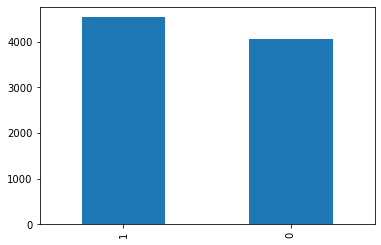

In [7]:
train_data['label'].value_counts().plot(kind = 'bar')

In [8]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0   4063
1      1   4532


In [9]:
train_data['review'] = train_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['review'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

review    7
star      0
label     0
dtype: int64


<ipython-input-9-9e844c844ba9>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['review'] = train_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
<ipython-input-9-9e844c844ba9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['review'] = train_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [10]:
test_data.drop_duplicates(subset = ['review'], inplace=True) # 중복 제거
test_data['review'] = test_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['review'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 2783


<ipython-input-10-1f0ed5dc41ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop_duplicates(subset = ['review'], inplace=True) # 중복 제거
<ipython-input-10-1f0ed5dc41ef>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['review'] = test_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
<ipython-input-10-1f0ed5dc41ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['review'] = test_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


In [17]:
okt = Okt()
stopwords = ['가','게','고','과','네','는','다','도','들','듯','를','에','와','으로',
             '은','을','의','이','인','임','자','잘','좀','지','하다','한']

In [484]:
X_train = []
for sentence in train_data['review']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [485]:
print(X_train[:3])

[['물건', '받다', '연결', '안되다', '리뷰', '보다', '핑크', '거의', '불량', '이다', '비싸다', '쓰레기', '산', '느낌', '이에요', '이렇다', '내용', '사전', '알다', '주다', '덜', '기분', '나빳을텐데', '요', '서비스', '센터', '가깝다', '분', '만', '사다', '저', '시간', '걸리다', '가다', '야하다', '장사', '똑바로'], ['거', '도대체', '뭔', '모르다'], ['배송', '엄청', '빠르다']]


In [486]:
X_test = []
for sentence in test_data['review']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)
print(X_test[:3])

[['품질', '만족', '밴드', '맘', '들다', '필름', '왜', '그렇게', '장애', '같다', '모르다', '붙이다', '누르다', '부분', '계속', '뜨다', '땔', '라', '그래도', '안때', '지고', '필름', '사지', '말다'], ['배송', '빠르다', '포장', '약간', '부실하다', '불안하다', '상품', '너무', '너무', '예쁘다'], ['갤럭시', '노트', '울트라', '말', '필요없다', '최고', '스마트폰', '이라고', '수', '있다', '성능', '디자인', '모두', '만족하다', '사은', '품', '중', '우산', '너무', '작다', '차안', '비상', '용', '두다', '무선', '충전', '패드', '갤럭시', '버즈', '충전', '되어다', '편하다', '사용', '하고', '있다']]


In [23]:
negative_words = np.hstack(train_data[train_data.label == 0].values)
print(len(negative_words))
print(negative_words)
positive_words = np.hstack(train_data[train_data.label == 1].values)
print(len(positive_words))
print(positive_words)

12189
['물건받고 연결이 안되서 리뷰를 보니 핑크는 거의 다 불량이였네요 비싼 쓰레기 산 느낌이에요 이런 내용을 사전에 알려줬더라면 덜 기분 나빳을텐데요 서비스센터 가까우신 분들만 사세요 저는 한시간 걸려 갔다와야하네요 장사 똑바로 하세요'
 1 0 ... '부모님께서 좋아하셔요 그런데 배송이 너무 늦습니다' 3 0]
13596
['이번에 출시된 풀렉스는  전 제품보가  디자인하고 성능이 더 심플하고 특히 키보드에 숫자키가 포함되 사용할때  편리하게 사용할수 장점입니다 이번에 기능인나 모두면이 좋은것 같습니다'
 4 1 ...
 '아들 선물로 구매했는데 미니도 역시 아이패드입니다    월 일에 주문해서 일 배송 시작 일에 받았습니다 월 주에 물건 입고' 5
 1]


In [26]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[(0, 4063), (3, 2391), (1, 1050), (2, 622), (nan, 5), ('좋긴한데 충전이 뜰려면 초 기다려야해요기계가 이상함                                           배송너무 늦어요어어                                          좋아요 좋아요 좋아요                                   배송은 늦었으나 상품은양품입니다    아이폰 와 프로 중 고민하다가 무게때문에 로 결정하고 화이트있어서 바로 구매                                     잘 받았습니다 이상없길 바래요    롯데는 요즘 같은 시기에 배송속도에 대해 신경좀 쓰셔야 할 듯 합니다쿠팡이나 컬리    구매한 지 한달되었습니다사용할수록 여기서 사길 잘했다는 생각이 듭니다     주문을 일날 하고 배송은 일에 받았어요배송은 빨리 와서 받았지만 양품인                                   역시 애플 넘깔끔하고 이쁘네요    애플워치를 사려고 고민한 지 어느덧 년이 되었어요에이 스마트워치가 뭐가 필                                비오는데 비닐로 한번더 포장 했음     상품 수급이 어렵다하시어 배송은 조금 늦어졌지만 그래도 양품으로 잘 도착했고 뽁뽁이    배송도 엄청 빨리왔구요 박스 첫개봉순간 설렘을 잊을수없네요 적은액수가 아니다보니                                    좋아아야아햐어요 호호후후하하랄랄                                           잘 돌아가고 좋아요    사자마자 월제조임에도 노이즈캔슬링 하자있었음리뷰를 보고 문제있을시 서비스센터에    착용감이좋고 조작방식이 터치가아닌 버튼식이라 좋고 커널형의 단점인 주위 바깥의 소리    배송 빠르고 제조일자 최신 걸로 받아서 좋아요 근데 미개봉 제품인데 왜 처음     에어팟 프로가 가지고 있는 노이즈 캔슬링 음질

In [27]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[(1, 4532), (5, 2593), (4, 1939), ('상품은 만족합니다배송은 좀 느려요    빠른배송 상품 다 좋습니다많이들 파세용                잘샀다 알람기능 너무 좋아요            빠른 배송과 저렴한 가격 감사합니다', 2), ('어머니사드렸는데 맘에 드신다고 좋아하시네요                            일에 주문하고 일에 도착했어요                 진짜 온라인 애플매장인줄 알고 샀는데 무튼 오긴왔으니까 다행임                                   배송이 생각보다 빨라서 좋습니다    잘 받았습니다다행히 양품인것 같아요 받자마자 바로 바꾸느라 지금 새폰으    옥천버뮤나에서 잠시 머물렀으나 무사 탈출하여 일정도 배송은 걸렸구요제품은 다                                 좋은 제춤을 좋은 가격에 잘 샀어요    배송은 엄청 빠르진 않았지만 불량인 부분도 없었고 무엇보다도 공홈에서 사는 것 보다                                           생각보다 배송 빠름                  일 걸린다 더니 빠르게 준비해서 보내주셨네요잘 사용하겠습니다                                    잘받았습니다감사합니다                                    년 월 제품을 받았네요              한쪽만 충전되는 불량이 왔어요 하러가야되겟네요배송은 참 빨랏습니다                                          배송이 빨라서 조아요    스마일 빅세일이랑 삼성카드 해서 만원에 개싸게삼일날 시켰는데 일날 옴    에어팟 프로는 전에 에어팟 세대 사용했던거랑 차원이 달랐습니다 노이즈캔슬링', 2), ('잘 도착했는데 박스 비닐 일부가 조금 벗겨져서 왔어요그대로 안전하게 도착했고                                            잘받았어요

In [ ]:
# Word2Vec TEST

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [34]:
train_data = pd.read_csv("C:/690009/TP2/final_project/Project/Data/shopping_ds.csv", encoding='utf-8-sig')
train_data

,Unnamed: 0,type,review,star
0,0,아이패드,택배가 이렇게 왔네요 정말 어이가 없어서전자제픔인데 물건을 이렇게 배송해주셔 ...,1
1,1,아이패드,택배가 이렇게 왔네요 정말 어이가 없어서전자제픔인데 물건을 이렇게 배송해주셔 ...,1
2,2,아이패드,고장나서 옴 수리하기도 돈아까윰 기쁜 마음으로 개봉했는데 액정은 아니지만 뒷면...,1
3,3,아이패드,고장나서 옴 수리하기도 돈아까윰 기쁜 마음으로 개봉했는데 액정은 아니지만 뒷면...,1
4,4,아이패드,그냥 모든게 허접해요 일단 사용해 보지 않아서 성능 기능 모릅니다시 이전 당일...,1
...,...,...,...,...
25824,25824,아이패드,다시는 오픈마켓에서 안살거에요 ㅎㅎ ㅜ 공홈에서 사야 교환하기도 편하고 좋을거같네요,1
25825,25825,아이패드,선물용으로 산거라 교환할 시간도 없어서 그냥 줬는데 모서리 찍혀있더라구요. 리퍼제...,1
25826,25826,아이패드,배송개ㅈ같이느리네주문한지가언젠데ㅋㅋ욕먹고싶어해서욕박는다재고없음연락해서먼저 조치를취하...,1
25827,25827,아이패드,미안하지도 않나봐요?,1


In [35]:
print(train_data.isnull().values.any())

False


In [36]:
train_data['review'] = train_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

<ipython-input-36-19cfc46fe654>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['review'] = train_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [37]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [38]:
# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()
tokenized_data = []
for sentence in train_data['review']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

리뷰의 최대 길이 : 1368
리뷰의 평균 길이 : 53.41387587595339


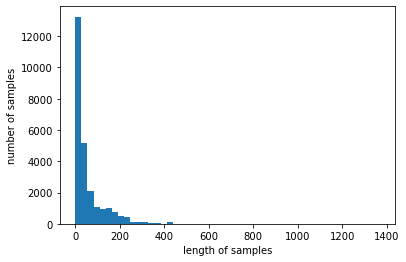

In [39]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [40]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


In [ ]:
model.wv.vectors.shape